In [1]:
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed, Flatten
from tensorflow.keras.layers import LSTM, GRU, RNN
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# import data into a dataframe
data = np.load('polution_dataSet.npy')

In [3]:
'''
IN this part data for test, validation and train is preperd.
'''
# data format is : pollution  ,dew  ,temp  , press ,wnd_dir , wnd_spd , snow , rain
# total data =43000
# per day and week = 43000/24*7 =250

SAMPLE_DISTANCE = 1      # if 1 sample per hour, if 24 per day, if 24*7 per week
TRAIN_SIZE = 7000
VAL_SIZE = 1000
TEST_SIZE = 2000
TIMESTEPS = 24           # timesteps used for a single prediction (here each timestep is an hour)

In [4]:
x_train = []
y_train = []
for i in range(TRAIN_SIZE):
    x_train.append(np.array(data[i*SAMPLE_DISTANCE:i*SAMPLE_DISTANCE+TIMESTEPS]))
    y_train.append(np.array(data[i*SAMPLE_DISTANCE+TIMESTEPS, 0]))
x_train = np.array(x_train)
y_train = np.array(y_train)

In [5]:
x_val = []
y_val = []
for i in range(TRAIN_SIZE, TRAIN_SIZE+VAL_SIZE):
    x_val.append(np.array(data[i*SAMPLE_DISTANCE:i*SAMPLE_DISTANCE+TIMESTEPS]))
    y_val.append(np.array(data[i*SAMPLE_DISTANCE+TIMESTEPS, 0]))
x_val = np.array(x_val)
y_val = np.array(y_val)

In [6]:
x_test = []
y_test = []
for i in range(TRAIN_SIZE+VAL_SIZE, TRAIN_SIZE+VAL_SIZE+TEST_SIZE):
    x_test.append(np.array(data[i*SAMPLE_DISTANCE:i*SAMPLE_DISTANCE+TIMESTEPS]))
    y_test.append(np.array(data[i*SAMPLE_DISTANCE+TIMESTEPS, 0]))
x_test = np.array(x_test)
y_test = np.array(y_test)
y_total = np.concatenate([y_train, y_val, y_test], axis=None)

In [7]:
'''
In this part network is implemented 
'''
# parameters
BATCH_SIZE = 10
NUM_EPOCHS = 20
HIDDEN_SIZE = 40

In [8]:
# class for RNN Keras
class MinimalRNNCell(keras.layers.Layer):

    def __init__(self, units, **kwargs):
        self.units = units
        self.state_size = units
        super(MinimalRNNCell, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      initializer='uniform',
                                      name='kernel')
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units),
            initializer='uniform',
            name='recurrent_kernel')
        self.built = True

    def call(self, inputs, states):
        prev_output = states[0]
        h = K.dot(inputs, self.kernel)
        output = h + K.dot(prev_output, self.recurrent_kernel)
        return output, [output]

In [9]:
# Let's use this cell in a RNN layer:
cell = MinimalRNNCell(HIDDEN_SIZE)

In [10]:
K.clear_session()
# keras modeling
model = Sequential()
model.add(RNN(cell, input_shape=(TIMESTEPS, 8), return_sequences=False))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn (RNN)                    (None, 40)                1920      
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
Total params: 1,961
Trainable params: 1,961
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, verbose=1, validation_data=(x_val, y_val))

Train on 7000 samples, validate on 1000 samples
Epoch 1/20
7000/7000 [==============================] - 5s 763us/step - loss: 0.0194 - val_loss: 0.0146
Epoch 2/20
7000/7000 [==============================] - 2s 337us/step - loss: 0.0154 - val_loss: 0.0144
Epoch 3/20
7000/7000 [==============================] - 2s 340us/step - loss: 0.0155 - val_loss: 0.0139
Epoch 4/20
7000/7000 [==============================] - 2s 337us/step - loss: 0.0152 - val_loss: 0.0149
Epoch 5/20
7000/7000 [==============================] - 2s 338us/step - loss: 0.0150 - val_loss: 0.0142
Epoch 6/20
7000/7000 [==============================] - 2s 340us/step - loss: 0.0150 - val_loss: 0.0163
Epoch 7/20
7000/7000 [==============================] - 2s 338us/step - loss: 0.0150 - val_loss: 0.0149
Epoch 8/20
7000/7000 [==============================] - 2s 339us/step - loss: 0.0147 - val_loss: 0.0142
Epoch 9/20
7000/7000 [==============================] - 2s 340us/step - loss: 0.0149 - val_loss: 0.0146
Epoch 10/20
7000

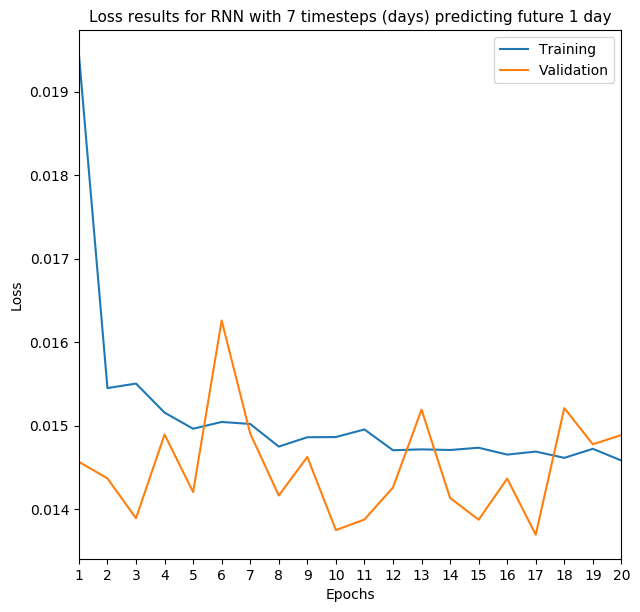

In [13]:
plt.figure(1, figsize=(7, 7), dpi=100)
plt.style.use(['default'])
plt.plot(np.arange(1,NUM_EPOCHS+1,1), history.history['loss'], label='Training')
plt.plot(np.arange(1,NUM_EPOCHS+1,1), history.history['val_loss'], label='Validation')
plt.xticks(np.arange(1, NUM_EPOCHS+1, 1, dtype=int))
plt.xlim(1, NUM_EPOCHS)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss results for RNN with 7 timesteps (days) predicting future 1 day', fontsize=11)
plt.legend()
plt.show()

In [14]:
print('train loss history:', history.history["loss"])
print('test loss history:', history.history["val_loss"])
scores = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE, verbose=1)
print('\nTest result loss: %.3f' % (scores))

train loss history: [0.019448476922365704, 0.01544955557810941, 0.015504039023071528, 0.01515619187682335, 0.014963189667157296, 0.01504406835517979, 0.015020323497841933, 0.014749120082706213, 0.014861053265631198, 0.014863457409664988, 0.01495457370366369, 0.014705238814598749, 0.01471593790587836, 0.014708412114663848, 0.01473532055172005, 0.014653238649480045, 0.0146894556922572, 0.014614332077825176, 0.014722502608783543, 0.014581988023460975]
test loss history: [0.014566708948696033, 0.014367957022041083, 0.013891266892896966, 0.014894022924127058, 0.014203900982392952, 0.016259678695350884, 0.014906305143376812, 0.014163165905047207, 0.014625169297214597, 0.013749253045534714, 0.01387515158043243, 0.014259973699226975, 0.015191646593157202, 0.014133971579140052, 0.01387318019522354, 0.014366032723337412, 0.01369384266086854, 0.015209806065540761, 0.01477667203405872, 0.014887721713166683]
2000/2000 [==============================] - 0s 129us/step

Test result loss: 0.014


In [15]:
y_train = model.predict(x_train, batch_size=BATCH_SIZE)
y_val = model.predict(x_val, batch_size=BATCH_SIZE)
y_pred = model.predict(x_test, batch_size=BATCH_SIZE)

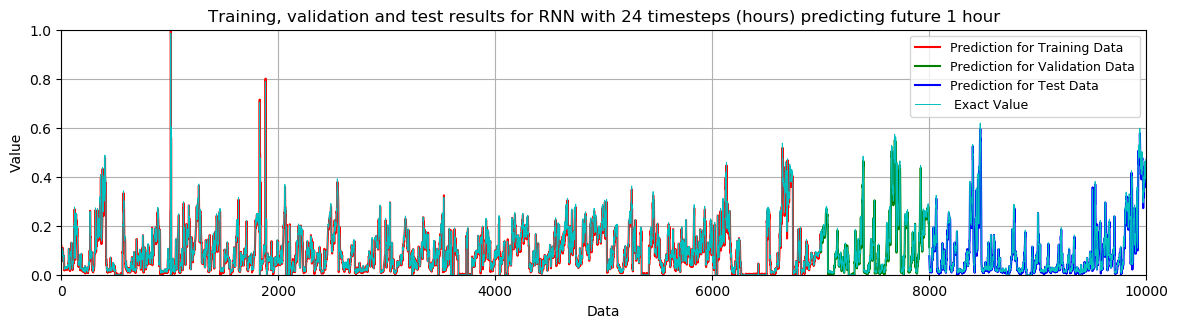

In [16]:
plt.figure(2, figsize=(14, 7), dpi=100)
plt.style.use(['default'])
plt.subplot(211)
plt.plot(range(0, TRAIN_SIZE), y_train, c='r', linewidth=1.5, label='Prediction for Training Data')
plt.plot(range(TRAIN_SIZE, TRAIN_SIZE+VAL_SIZE), y_val, c='g', linewidth=1.5, label='Prediction for Validation Data')
plt.plot(range(TRAIN_SIZE+VAL_SIZE, TRAIN_SIZE+VAL_SIZE+TEST_SIZE), y_pred, c='b', linewidth=1.5, label='Prediction for Test Data')
plt.plot(range(0, TRAIN_SIZE+VAL_SIZE+TEST_SIZE), y_total, c='c', linewidth=0.7, label=' Exact Value')
plt.xlim(0, TRAIN_SIZE+VAL_SIZE+TEST_SIZE)
plt.ylim(0, 1)
plt.xlabel('Data')
plt.ylabel('Value')
plt.title('Training, validation and test results for RNN with 24 timesteps (hours) predicting future 1 hour')
plt.legend(loc='best', fontsize=9)
plt.grid(True)
plt.show()

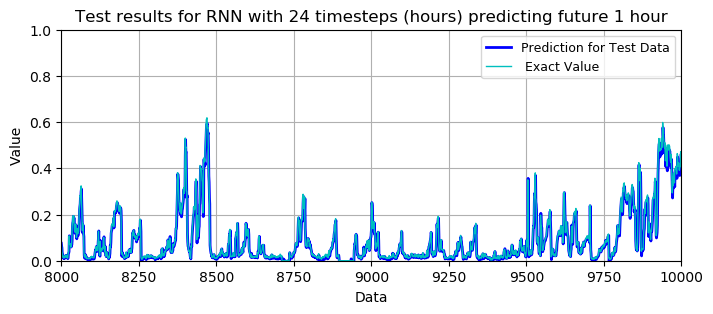

In [17]:
plt.figure(3, figsize=(8, 3), dpi=100)
plt.style.use(['default'])
plt.plot(range(TRAIN_SIZE+VAL_SIZE, TRAIN_SIZE+VAL_SIZE+TEST_SIZE), y_pred, 'b', linewidth=2, label='Prediction for Test Data')
plt.plot(range(TRAIN_SIZE+VAL_SIZE, TRAIN_SIZE+VAL_SIZE+TEST_SIZE), y_total[TRAIN_SIZE+VAL_SIZE:TRAIN_SIZE+VAL_SIZE+TEST_SIZE], c='c', linewidth=1, label=' Exact Value')
plt.xlim(TRAIN_SIZE+VAL_SIZE, TRAIN_SIZE+VAL_SIZE+TEST_SIZE)
plt.ylim(0, 1)
plt.xlabel('Data')
plt.ylabel('Value')
plt.title('Test results for RNN with 24 timesteps (hours) predicting future 1 hour')
plt.grid(True)
plt.legend(loc='best', fontsize=9)
plt.show()